In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, laplace, beta, bernoulli, expon
#import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import warnings 
import pystan
import arviz
warnings.filterwarnings('ignore')

# Introduction to Bayesian Modeling (Part 1b)

In this session, we will try to perform the Bayesian inference on simple examples. We won't rely on *conjugate* priors, but will explore the possibilities of *MCMC*-based inference. Tomorrow, we will learn more about MCMC.

Generally, we will proceed in three steps:
1. We construct a model. That is, we need to decide the distribution of the data.
2. We choose a convenient prior distribution for inference of unknown model parameters.
3. We run estimation and analyze results.

Two additional software packages will be used:
- *stan* and its python interface *pystan*
- *arviz* for visualization of the results.

## Example 1: Coin tossing

The first example introduces the basics of *stan* and *pystan*. The task is:
1. simulate `ndat` tosses of a coin (pings, detections of something...) using a known probability of head (success, presences of a phenomenon...);
2. try to infer this (here known) probability from the data.

We already know that the binary 0-1 data where 1 occurs with probability $p$ follows the Bernoulli distribution

$$
x \sim \mathrm{Bernoulli}(p).
$$

The `scipy.stats` package contains the `bernoulli` class, whose `rvs()` method produces (pseudo)random sampling:

In [2]:
ndat = 1000
p = 0.7
x = bernoulli.rvs(p=p, size=ndat)

print(f'Number of ones: {x.sum()}.')
print(f'Number of zeros: {ndat - x.sum()}')
print(f'Estimated probability: {x.sum()/ndat:.3f}')

Number of ones: 713.
Number of zeros: 287
Estimated probability: 0.713


Above we obtained a (frequentist) estimate of $p$, but cannot directly say, how much uncertain it is. For this purpose, we exploit the Bayesian paradigm and set a prior. Although we won't rely on *conjugate priors* in the sequel, we will stick with the beta distribution just for illustration. Recall, that the beta distribution has two positive real parameters $a$ and $b$, that represent the number of successes and failures.

We have

$$
p \sim \mathrm{beta}(a, b).
$$

If $a=b=1$, the distribution coincides with the uniform distribution over the interval $[0, 1]$. The posterior is defined by

$$
\begin{aligned}
a_1 &= a + \text{number of successes}, \\
b_1 &= b + \text{number of failures}.
\end{aligned}
$$

We will check it later.

### (py)stan

Shortly: [stan](https://mc-stan.org) is a software for statistical modeling. It is incredibly powerful, we will only superficially explore its qualities.

Our first (py)stan code is fairly simple. We need to define three blocks:
- `data` - properties of data and its type, size, and limits,
- `parameters` - properties of inferred parameters (in our case the probability). Type, size, and limits.
- `model` - the probabilistic form of the model, i.e., the data model (here Bernoulli) and the prior distributions (here the beta distribution).

The definition serves for compilation to C++ which is obvious from the code:

In [3]:
model_code = """
data {
    int<lower=0> N;                    // number of data items
    int<lower=0,upper=1> x[N];         // data (observations)
}

parameters {
    real<lower=0,upper=1> p;           // estimated variable
}

model {
    p ~ beta(1, 1);  // prior for the mean
    
    for(n in 1:N) {
        x[n] ~ bernoulli(p); // data model
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89efa206b8bc30f0f520275cbc35217f NOW.


Next, we define a pythonic dictionary for the `data` block:

In [4]:
data = {
    'x': x,
    'N': ndat
}

Inference is performed by the `sampling()` method. It accepts a bunch of arguments, here we see:
- reference to the `data` dictionary
- `iter` stands for the number of MCMC iterations (i.e., samples from the posterior distribution)
- `chains` is the number of MCMC chains. Will become clear tomorrow
- `verbose` is clear :)

In [5]:
fit = sm.sampling(data=data, iter=100000, chains=1, verbose=True)

Let's look at the result! We see:
- the number of iterations and chains
- `thin` and `warmup` will be explained tomorrow
- the table depicts
    - `mean` - the mean of the posterior samples
    - `se_mean` - MC standard error: the estimated standard deviation of a parameter divided by the square root of the number of effective samples (tricky, isn't it? :))
    - `sd` - standard deviation of the samples
    - `2.5` and `97.5` percentiles delimiting 95% credibility regions
    - all three `quartiles`
    - `n_eff` - number of effective samples - the higher the better
    - `Rhat` - the Gelman-Rubin diagnostic. A rule of thumb for a good convergence is value smaller than 1.1.
    
If the chain(s) do not converge, `stan` will inform us.

In [6]:
print(fit)

Inference for Stan model: anon_model_89efa206b8bc30f0f520275cbc35217f.
1 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=50000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.71  1.1e-4   0.01   0.68    0.7   0.71   0.72   0.74  16264    1.0
lp__ -601.5  6.4e-3   0.72 -603.6 -601.7 -601.2 -601.0 -601.0  12517    1.0

Samples were drawn using NUTS at Sun Jul 19 23:36:54 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Next, we look at the posterior distribution using the `arviz` package. First, we transform the result into the arviz-friendly form:

In [7]:
inferencedata = arviz.from_pystan(posterior=fit)

...and plot the trace and the estimate of the posterior distribution. Arviz can produce a lot of nice plots, it is worth to explore a bit :)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb880af4130>,
      dtype=object)

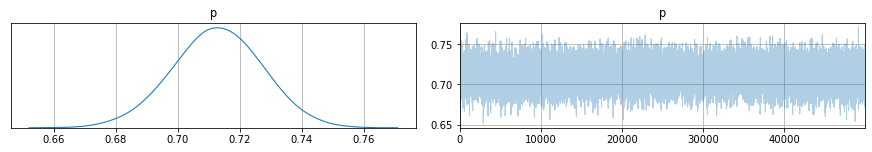

In [8]:
arviz.plot_trace(inferencedata)

#### Back to the conjugate prior :)

...and plot the true beta posterior density:

In [9]:
trace = fit.extract(pars='p')

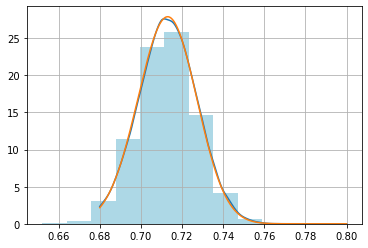

In [10]:
a = b = 1
a1 = a + x.sum()
b1 = b + (ndat - x.sum())

xticks = np.linspace(0.68, 0.8, 1000)
from scipy.stats import gaussian_kde
kde_res = gaussian_kde(trace['p'])
plt.hist(trace['p'], density=True, color='lightblue')
plt.plot(xticks, kde_res(xticks))

plt.plot(xticks, beta.pdf(xticks, a1, b1))

## Example 2: Housefly wing lengths

In this example we aim at estimation of the mean and standard deviation of a normal (Gaussian) distribution. The dataset contains the housefly wing lengths originating from

*Sokal, R.R. and P.E. Hunter. 1955. A morphometric analysis of DDT-resistant and non-resistant housefly strains Ann. Entomol. Soc. Amer. 48: 499-507*

This set is considered an excelent real example of normally distributed biometric data.

First, we will load the data and plot their histogram, including the point estimates of the mean a standard deviation:

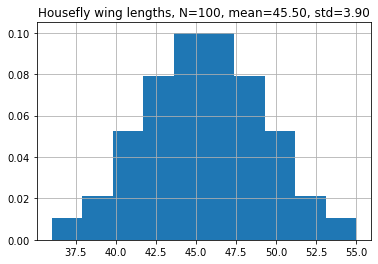

In [11]:
y = np.loadtxt('housefly.txt')
plt.hist(y, density=True)
plt.title(f'Housefly wing lengths, N={y.size}, mean={y.mean():.2f}, std={y.std():.2f}')
plt.show()

A wise question could be: are the estimates precise? What is our uncertainty about them? We have only a finite and relatively small number of data, after all.

This is, where the Bayesian approach to modeling becomes handy. First, we define the model and prior distributions:
- data `y` will follow a normal distribution with unknown mean `mu` and standard deviation `std`
- the mean `mu` will be estimated using a normal prior distribution
- the standard deviation `std` will be estimated using a gamma prior

To summarize:
$$
\begin{aligned}
y &\sim \mathcal{N}(\mu, \sigma^2), \\
\mu &\sim \mathcal{N}(\cdot, \cdot), \\
\sigma &\sim \mathcal{G}(\cdot, \cdot).
\end{aligned}
$$

A natural question is how to decide the prior. There are some guidelines, e.g.
- is the estimated parameter bounded? E.g., is it strictly positive?
    - if yes, then we need either a convenient transformation so that it's unbounded, or a bounded prior. A frequent choice is the gamma prior.
- how solid is our knowledge about the parameter? If I choose a gamma prior, how do I know it is vague enought?
    - P. Lambert, A. Sutton, P. Burton, K. Abrams, and D. Jones, “How vague is vague? A simulation study of the impact of the use of vague prior distributions in MCMC using WinBUGS,” Stat. Med., vol. 24, no. 15, pp. 2401–2428, Aug. 2005.

In [12]:
model_code = """
data {
    int<lower=0> N;      // number of data items
    vector[N] y;         // data (observations)
}

parameters {
    real mu;             // estimated mean
    real<lower=0> std;   // estimated standard dev.
}

model {
    mu ~ normal(50, 100); // prior for the mean
    std ~ gamma(2, 0.1);  // prior for st. dev.
    y ~ normal(mu, std);  // data model
}
"""

sm_housefly = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aebbc33c8c5eba02d675435f653c0e21 NOW.


Now, we're ready for inference on real data:

In [13]:
data = {
    'y': y,
    'N': y.size
}

fit_housefly = sm_housefly.sampling(data=data, iter=100000, chains=1, verbose=True)
print(fit_housefly)

Inference for Stan model: anon_model_aebbc33c8c5eba02d675435f653c0e21.
1 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=50000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     45.5  1.8e-3    0.4  44.71  45.23   45.5  45.76  46.28  49544    1.0
std    3.98  1.3e-3   0.29   3.47   3.78   3.96   4.17    4.6  48215    1.0
lp__ -184.7  6.7e-3   1.01 -187.4 -185.1 -184.4 -184.0 -183.7  22441    1.0

Samples were drawn using NUTS at Sun Jul 19 23:37:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb880b155e0>,
      dtype=object)

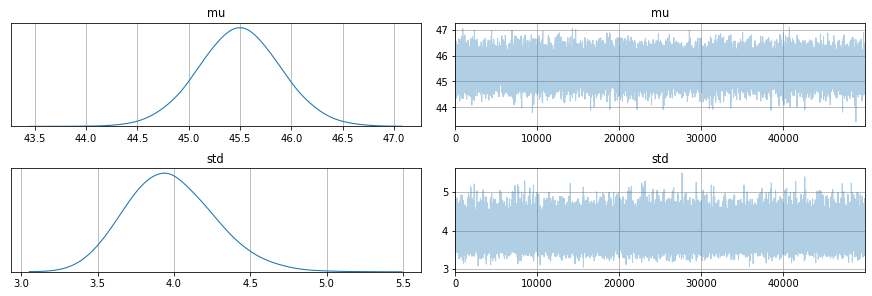

In [14]:
inferencedata_housefly = arviz.from_pystan(posterior=fit_housefly)
arviz.plot_trace(inferencedata_housefly)

If we obtain new measurements, we can use the posterior distributions and update them by new data! :)

**Misleading priors:** Try setting a conceptually wrong prior distribution for the mean. E.g., very concentrated on a region far from the (true) mean.

## Example 3: Time to event modeling (50)
**(Checking the the posterior predictive)**

In this example we will study the problem of time-to-event modeling. We have a detector that observes a particle flux. The particles arrive independently at a constant rate. The time between two consecutive detections is described by data in the file. The goal is to estimate the rate parameter.

It is well known that the waiting times of such processes follow the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) with the positive real **rate** parameter $\lambda$:

$$
y \sim \mathrm{Exp}(\lambda), \qquad \lambda>0.
$$

Your task is to estimate $\lambda$.

(array([41.97368161, 27.79338377, 14.18029784, 12.4786621 ,  5.67211914,
         4.53769531,  1.70163574,  3.40327148,  0.56721191,  1.13442383]),
 array([0.00014396, 0.008959  , 0.01777405, 0.0265891 , 0.03540415,
        0.04421919, 0.05303424, 0.06184929, 0.07066434, 0.07947938,
        0.08829443]),
 <a list of 10 Patch objects>)

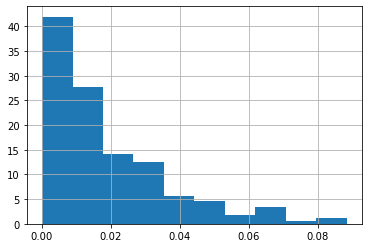

In [15]:
data = np.load('time-to-event.npz')
y = data['y']
plt.hist(y, density=True)

Well, the task is to fit the parameter $\lambda$. In addition, we want to calculate the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), which allows to more investigate the quality of fit. It is given by

$$
f(\tilde{y}_i|y_1,\ldots,y_N) = \int f(y_i|\lambda) \pi(\lambda) \mathrm{d}\lambda,
$$

i.e., the posterior predictive is obtained from **averaging over the parameter**.

In [16]:
model_code = """
data {
    int<lower=0> N;          // number of data items
    vector[N] y;             // data (observations)
}

parameters {
    real<lower=0> lambda;    // estimated rate parameter
}

model {
    lambda ~ gamma(0.001, 0.001);  // prior for lambda
    y ~ exponential(lambda);       // data model
}

generated quantities {             // here we calculate posterior predictive
    real yhat[N];                  // this is the predicted observation
    
    for (n in 1:N) {
         yhat[n] = exponential_rng(lambda);    // we sample it from the rng with lambda est.
    }
}
"""

sm_tte = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1910dc8778701e765c664e01515cb7a1 NOW.


In [17]:
data = {
    'y': y,
    'N': y.size
}

fit_tte = sm_tte.sampling(data=data, iter=100000, chains=1, verbose=True)

Let's look at the summary. If we want to filter out the predictive distributions, we have to limit ourselves a bit...

In [18]:
print(fit_tte.stansummary(pars='lambda'))

Inference for Stan model: anon_model_1910dc8778701e765c664e01515cb7a1.
1 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=50000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda  52.39    0.03   3.69  45.41  49.85  52.29  54.82  59.92  21575    1.0

Samples were drawn using NUTS at Sun Jul 19 23:39:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [19]:
inferencedata_tte = arviz.from_pystan(posterior=fit_tte, posterior_predictive='yhat', observed_data='y')

Let's assess the traceplots...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb87c413ee0>,
      dtype=object)

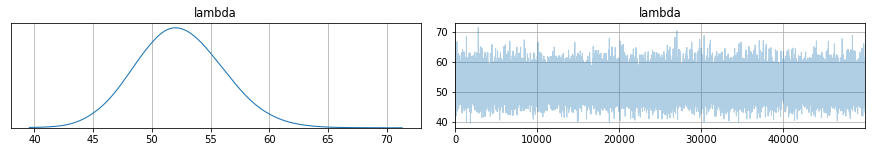

In [20]:
arviz.plot_trace(inferencedata_tte)

...and posterior predictive. The true observations should be well covered.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb877f71100>],
      dtype=object)

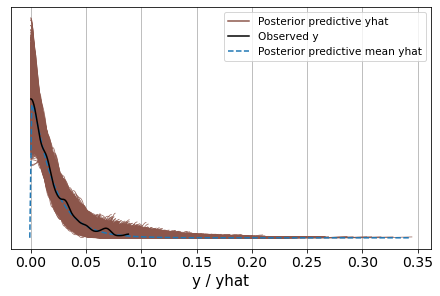

In [21]:
arviz.plot_ppc(inferencedata_tte, data_pairs = {'y': 'yhat'}, alpha=0.9)

Try to set an inconvenient prior, e.g., uniform on [0, 10], and check.